Optimal Transport with Benamou-Brenier Algorithm
================================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


This numerical details how to compute optimal transport maps by solving a space-time
convex variational problem.


This tour implements the algorithm described in:


Benamou J.-D.; Brenier Y.,
_A computational fluid mechanics solution of the Monge-Katonrovich mass transfer problem_,
Numer. Math. 84 (2000), pp. 375-393


The algorithm detailed in this paper is introduced as an
augmented-Lagrangia method over the Legendre-Fenchel dual variational
problem. In this tour, we introduce a proximal algorithm (Douglas-Rachford) directly over
the primal algorithm. Both algorithm can be shown to be equivalent, but we feel that explaining a primal
algorithm was conceptually simpler and fits nicely in the well developped framework of proximal splitting schemes.


Special thanks to Jalal Fadili for advices for the implementation of the
proximal solver.

In [2]:
addpath('toolbox_signal')
addpath('toolbox_general')
addpath('solutions/optimaltransp_2_benamou_brenier')

Usaful helpers.

In [2]:
mynorm = @(a)norm(a(:));
sum3 = @(a)sum(a(:));

Optimal Transport of Densities
------------------------------
We consider transport $T : [0,1]^2 \mapsto [0,1]^2 $
with periodic boundary conditions.


A valid transport should push forward the measure $ f_0(x) d x$
onto $ f_1(x) d x $. In term of densities, this corresponds to
the constraint

$$ f_0(x) = f_1(T(x)) \abs{\det( \partial T(x) )} $$

where $\partial T(x) \in \RR^{2 \times 2}$ is the differential of $T$
at $x$. This is known as the gradient equation.
We call $\Tt(f,g)$ the set of transport that satisfies this constraint.


Optimal transport looks for a mapping that solves
$$ W(f_0,f_1) = \umin{T \in \Tt(f_0,f_1) } \int C(x,T(x)) d x $$
where $C(x,y) \geq 0$ is the cost of assigning $x \in [0,1]^2$ to $y \in
[0,1]^2$.


We consider here the $L^2$ optimal transport, so that
$C(x,y)=\norm{x-y}^2$.


The optimal transport geodesic $f(x,t)$ is defined as
$$ f(x,t) = f_1( (1-t) \text{Id} + t T(x))
   \abs{\det( (1-t) \text{Id}  + t \partial T(x) )}. $$


Benamou and Brenier showed that this geodesic solves the following convex
problem over $f(x,t) \in \RR^+, m(x,t) \in \RR^2 $
$$ \umin{ (m,f) \in \Cc } J(f) =
      \int_{[0,1]^2} \int_0^1 \frac{\norm{m(x,t)}^2}{f(x,t)} d t d x, $$
where the set of constraints reads
$$ \Cc = \enscond{(m,f)}{ \text{div}(m)+\partial_t f = 0,
      \quad f(\cdot,0)=f_0, \quad f(\cdot,1)=f_1  }. $$


Note that this convex program is very challenging because:
1/ The functional $J$ tends to zero when $f(x,t)$ tends to
infinity at some points, so that it is not coercive, which makes the
proof of existence of minimizers non-trivial.
2/ The functional $J(m,f)$ tends to infinity when $f(x,t)$ tends to
zero at some points which makes the use of gradient descent methods impossible
(its gradient is not Lipschitz).


We propose to use a proximal method scheme (Douglas-Rachford algorithm)
that can handle this kind of problem. It is equivalent to the algorithm
initially proposed by Benamou and Brenier.


Discrete Variational Problem
----------------------------
Densities is discretized on a spacial rectangular grid of size $N = n \times
n$. The time domain $[0,1]$ is discretized with $p$ points.

In [1]:
n = 20;
p = 20

p =  20


Shortcut to generate Gaussian function.

In [3]:
[Y,X] = meshgrid(linspace(0,1,n), linspace(0,1,n));
gaussian = @(a,b,sigma)exp( -((X-a).^2+(Y-b).^2)/(2*sigma^2) );
normalize = @(u)u/sum(u(:));

Load two discretized densities $f_0,f_1$.

In [4]:
sigma = .1;
rho = .05; % minimum density value
f0 = normalize( rho + gaussian(.2,.3,sigma) );
f1 = normalize( rho + gaussian(.6,.7,sigma*.7) + .6*gaussian(.7,.4,sigma*.7) );

Display $f_0,f_1$.

In [5]:
clf;
imageplot({f0 f1});

error: 'imageplot' undefined near line 1 column 1


Inline plot failed, consider trying another graphics toolkit
error: print: no axes object in figure to print
error: called from
    _make_figures>safe_print at line 125 column 7
    _make_figures at line 49 column 13



Boundary conditions, either periodic or Neumann.

In [6]:
bound = 'per';
bound = 'neum';

We use first order finite differences with periodic boundary condition to
approximate the spacial derivatives.

In [7]:
if strcmp(bound, 'per')
    dx = @(u)u([2:end 1],:,:)-u;
    dy = @(u)u(:,[2:end 1],:)-u;
else
    dx = @(u)u([2:end end],:,:)-u;
    dy = @(u)u(:,[2:end end],:)-u;
end

The adjoint operators are backward derivatives.

In [8]:
if strcmp(bound, 'per')
    dxS = @(u)-u+u([end 1:end-1],:,:);
    dyS = @(u)-u+u(:,[end 1:end-1],:);
else
    dxS = @(u)[-u(1,:,:); u(1:end-2,:,:)-u(2:end-1,:,:); u(end-1,:,:)];
    dyS = @(u)[-u(:,1,:), u(:,1:end-2,:)-u(:,2:end-1,:), u(:,end-1,:)];    
end

Check that |dxS| and |dyS| really implement $d/dx^*$ and $d/dy^*$.

In [9]:
fprintf('Should be 0: %.2e\n', certify_adjoint(dx,dxS,[n n p]));
fprintf('Should be 0: %.2e\n', certify_adjoint(dy,dyS,[n n p]));

error: 'certify_adjoint' undefined near line 1 column 32
error: 'certify_adjoint' undefined near line 1 column 32


Define spacial gradient and divergence, satisfying $\text{div}=-\nabla^*$.

In [10]:
grad = @(f)cat(4, dx(f), dy(f));
div  = @(u)-dxS(u(:,:,:,1)) - dyS(u(:,:,:,2));

In [12]:
div

div =

@(u) -dxS (u (:, :, :, 1)) - dyS (u (:, :, :, 2))



Check that |div| really implements div.

In [13]:
fprintf('Should be 0: %.2e\n', certify_adjoint(grad,@(v)-div(v),[n n p]));

error: 'certify_adjoint' undefined near line 1 column 32


We use first order finite differences for the time derivatives.
Note that zero is padded at the end to keep the same dimensionality.

In [14]:
dt  = @(f)cat(3, f(:,:,2:end)-f(:,:,1:end-1), zeros(size(f,1),size(f,2)) );
dtS = @(u)cat(3, -u(:,:,1), u(:,:,1:end-2)-u(:,:,2:end-1), u(:,:,end-1));

In the following, we group the dicrete variables as $w=(m,f) \in \RR^{N
\times P \times 2} \times \RR^{N \times P}$, which is stored in a matrix
|w| of size |(n,n,p,3)|, so that $m$ is stored in |w(:,:,:,1:2)|
and $f$ is stored in |w(:,:,:,3)|.


We thus introduce the following convex functional for $w=(m,f)$
$$ J(w) =  \sum_{x,t} \frac{\norm{m(x,t)}^2}{f(x,t)}. $$
where $(x,t)$ runs over the discrete 3-D grid.


The affine set of constraints reads
$$ \Cc = \enscond{w}{A w = r_0}$
      \qwhereq A w = (\text{div}(m) + \partial_t f, f(\cdot,0), f(\cdot,1) ) \in \RR^{N \times (P+2) }  $$
and where the right hand size reads $r_0 = (0,f_0,f_1)$.

In [15]:
A = @(w)cat( 3, div(w(:,:,:,1:2))+dt(w(:,:,:,3)), w(:,:,1,3), w(:,:,end,3) );

Its adoint reads, for all $r=(s, r_0,r_1)$ where $s \in \RR^{N \times
P}$ and $r_0,r_1 \in \RR^N$:
$$ A^* r = ( -\nabla s, \partial_t^* s + U(r_0,r_1) ) $$
where $U(r_0,r_1)$ is the zero-padding operator that puts zeros for
intermediate times between $t=0$ and $t=1$.

In [16]:
U = @(r0,r1)cat(3, r0, zeros(n,n,p-2), r1);
AS = @(s)cat(4, -grad(s(:,:,1:p)), dtS(s(:,:,1:p)) + U(s(:,:,end-1),s(:,:,end)) );

Check that |AS| really implements $A^*$.

In [17]:
fprintf('Should be 0: %.2e\n', certify_adjoint(A,AS,[n n p 3]));

Should be 0: 3.30e-15


Define the right hand side $r_0$.

In [18]:
r0 = cat(3, zeros(n,n,p), f0, f1);

Proximal Operator of the $J$ Functional
-----------------------------------------
Given a convex functional $J(w)$, its proximal operator is defined as
$$ \text{Prox}_{\la J}(w) = \uargmin{q} \frac{1}{2} \norm{w-q}^2 + \la J(w). $$
Being abble to compute this proximate mapping is crucial to be able to
use various proximal-splitting convex optimization methods.


The discrete functional to be minimized in the Brenier-Benamou problem reads
$$ J(w) = \sum_{x,t} j(m(x,t),f(x,t)) $$
where we introduced the following convex function
$$ \forall (m,f) \in \RR^2 \times \RR^+, \quad j(m,f) ) = \frac{\norm{m}^2}{f}. $$


Define the $J$ functional.

In [17]:
J = @(w)sum3(  sum(w(:,:,:,1:2).^2,4) ./ w(:,:,:,3)   );

The proximal operator of $J$ can thus be computed by applying the
proximal operator of $j$ to each component, i.e.
$$ \text{Prox}_{\la J}(w)(x,t) = \text{Prox}_{\la j}(w(x,t)). $$


The proximal operator of $j$
$$ (m,f) = \text{Prox}_{\la j}(m_0,f_0) $$
is obtained by solving the following couple of equations (corresponding
to the annulation of the derivative of the optimization problem defining
the proximal map)
$$
      2 \la \frac{m}{f} + m-m_0=0 \qandq -\la \frac{\norm{m}^2}{f^2} +
      f-f_0 = 0.
$$
Its solution is obtained by solving a cubic-equation
$$
      m = \frac{m_0}{1+2\la/f} \qandq
      P(f) = f^3 + (4\lambda - f_0)f^2 + (4\lambda^2-4\lambda f_0)f -
      (\lambda \norm{m_0}^2 + 4\lambda^2 f_0) = 0.
$$
(only the largest real solution of this equation should be considered).


Build the coefficients of the polynomial $P(f)$.

In [18]:
PolyCoef = @(m0,f0,lambda)[ones(length(f0),1), 4*lambda-f0, 4*lambda^2-4*f0, -lambda*sum(m0.^2,2) - 4*lambda^2*f0];

Helper to compute the leading (largest) real root of a cubic polynomial.

In [19]:
extract = @(A)A(:,1);
CubicReal = @(P)real( extract(poly_root(P')') );

Define the proximal operator of $j$. Note that it can operate in
parallel over arrays |m| of size $k \times 2$ and |f| of size $k \times 1$

In [20]:
Proxj0 = @(m0,f, lambda)cat(2, m0 ./ repmat( 1+2*lambda./f, [1 2]), f );
Proxj  = @(m0,f0,lambda)Proxj0( m0, CubicReal(PolyCoef(m0,f0,lambda)), lambda );

Define the proximal operator of $J$ using the proximal operator of
$j$.

In [21]:
ProxJ = @(w,lambda)reshape( Proxj( ...
                   reshape(w(:,:,:,1:2), [n*n*p 2]), ...
                   reshape(w(:,:,:,3  ), [n*n*p 1]), lambda ), [n n p 3] );

Orthogonal Projection on the Constraints
----------------------------------------
The proximal operator of the indicator function $G=\iota_\Cc$ of $\Cc$ is the
projector, and does not depend on $\la$.
$$ \text{Prox}_{\gamma \iota_\Cc}(x)_i =
      \text{Proj}_\Cc(w) = w + A^* (A A^*)^{-1} (r-Aw). $$


Tolerance and number of iterations for the conjugate gradient.

In [22]:
opts.epsilon = 1e-9; 
opts.niter_max = 150;

Adapt conjugate gradient fucntion to handle variables that are not
vectors.

In [23]:
flat = @(x)x(:);
resh = @(x)reshape(x, [n n p+2]);
mycg = @(B,y)resh( perform_cg(@(r)flat(B(resh(r))),y(:),opts) );

The operator $(A A^*)^{-1}$ can be computed using conjugate gradient.

In [24]:
pA = @(r)mycg(@(s)A(AS(s)),r);

Define the projection operator $\text{Prox}_{\la G}$.

In [25]:
ProxG = @(w,lambda)w + AS( pA(r0-A(w)) );

Check that $\text{Prox}_{\la G}$ implements the projection on the
constraint $Aw=y$.

In [26]:
w = randn(n,n,p,3);
err = @(w)mynorm(A(w)-r0)/mynorm(r0);
fprintf('Error before projection: %.2e\n', err(w));
fprintf('Error before projection: %.2e\n', err(ProxG(w)));

error: 'r0' undefined near line 1 column 23
error: called from
    @<anonymous> at line 1 column 26
error: 'r0' undefined near line 1 column 31
error: called from
    @<anonymous> at line 1 column 22


Douglas-Rachford Solver
-----------------------
The discrete optimal transport problem can be written as
$$ \umin{w} J(w) + G(w) \qwhereq G=\iota_{\Cc}.  $$


The Douglas-Rachford (DR) algorithm is an iterative scheme to minimize
functionals of the form $J+G$
where $J$ and $G$ are convex functions for which one is able to
comptue the proximal operators.


A DR iteration reads
$$ \tilde w_{k+1} = \pa{1-\frac{\mu}{2}} \tilde w_k +
  \frac{\mu}{2} \text{rPox}_{\gamma J}( \text{rProx}_{\gamma G}(\tilde w_k)  )
  \qandq w_{k+1} = \text{Prox}_{\gamma G}(\tilde w_{k+1}). $$


We have use the following shortcuts:
$$   \text{rProx}_{\gamma G}(w) = 2\text{Prox}_{\gamma F}(w)-w $$


One can show that for any value of $\gamma>0$, any $ 0 < \mu < 2 $,
and any $\tilde w_0$, $w_k \rightarrow w^\star$
which is a minimizer of the minimization of $J+G$.


To learn more about this algorithm, you can read:


_Proximal Splitting Methods in Signal Processing_, Patrick L. Combettes
and Jean-Christophe Pesquet, in: Fixed-Point Algorithms for Inverse
Problems in Science and Engineering, New York: Springer-Verlag, 2010.



Set the value of $\mu$ and $\gamma$.
You might consider using your own values to speed up the convergence.

In [27]:
mu = 1;
gamma = 1;

Define the rProx operators.

In [28]:
rProxJ = @(w,tau)2*ProxJ(w,tau)-w;
rProxG = @(w,tau)2*ProxG(w,tau)-w;

Number of iterations.

In [29]:
niter = 200;

Initialization using linear interpolation of the densities.

In [30]:
t = repmat( reshape(linspace(0,1,p), [1 1 p]), [n n 1]);
f = (1-t) .* repmat(f0, [1 1 p]) + t .* repmat(f1, [1 1 p]);
m = zeros(n,n,p,2);
w0 = cat(4, m,f);

Display the initialization.

In [31]:
sel = round(linspace(1,p,6));
clf;
imageplot( mat2cell(w0(:,:,sel,3), n, n, ones(6,1)) , '', 2,3);

error: 'imageplot' undefined near line 1 column 1


Inline plot failed, consider trying another graphics toolkit
error: print: no axes object in figure to print
error: called from
    _make_figures>safe_print at line 125 column 7
    _make_figures at line 49 column 13



In [32]:
w = ProxG(w0,gamma);
mynorm(A(w0)-r0)/mynorm(r0)
mynorm(A(w)-r0)/mynorm(r0)

error: 'r0' undefined near line 1 column 31
error: called from
    @<anonymous> at line 1 column 22
error: 'r0' undefined near line 1 column 14
error: 'r0' undefined near line 1 column 13


__Exercise 1__

Implement the DR iterative algorithm on |niter| iterations.
Keep track of the evolution of the energy $J$.

[Warning: Input tol may not be achievable by CGS
         Try to use a bigger tolerance] 
[> In cgs at 297
  In perform_cg at 56
  In @(B,y)resh(perform_cg(@(r)flat(B(resh(r))),y(:),opts))
  In @(r)mycg(@(s)A(AS(s)),r)
  In @(w,lambda)w+AS(pA(r0-A(w)))
  In exo1 at 6
  In pymat_eval at 38
  In matlabserver at 27] 
[Warning: Input tol may not be achievable by CGS
         Try to use a bigger tolerance] 
[> In cgs at 297
  In perform_cg at 56
  In @(B,y)resh(perform_cg(@(r)flat(B(resh(r))),y(:),opts))
  In @(r)mycg(@(s)A(AS(s)),r)
  In @(w,lambda)w+AS(pA(r0-A(w)))
  In exo1 at 6
  In pymat_eval at 38
  In matlabserver at 27] 


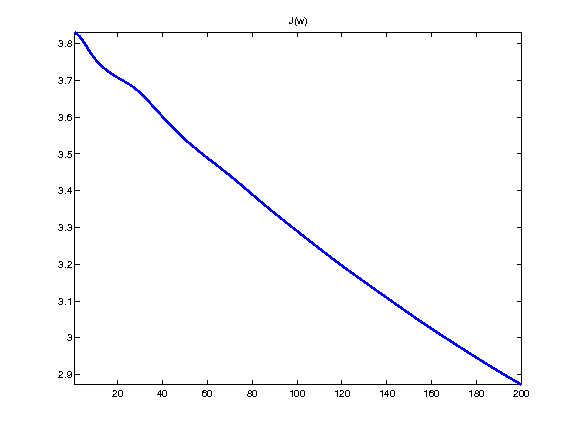

In [35]:
exo1()

In [36]:
%% Insert your code here.

Display the resulting density $f(x,t)$ for $t$ from 0 to 1.

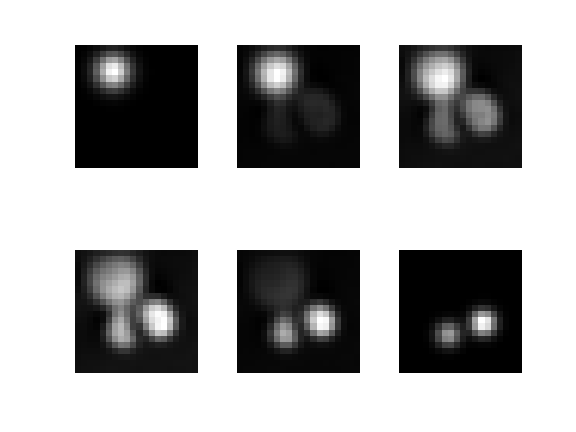

In [37]:
sel = round(linspace(1,p,6));
clf;
imageplot( mat2cell(w(:,:,sel,3), n, n, ones(6,1)) , '', 2,3);